# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
!pip install --upgrade pip
!pip install imageio
!pip install scikit-image
!pip install matplotlib
# !pip install tensorflow
!pip install tensorflow[and-cuda]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.0 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 23.3.1
    Uninstalling pip-23.3.1:
      Successfully uninstalled pip-23.3.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 49.0 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 68.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 43.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 71.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.6/412.6 MB 68.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 69.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 59.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━

In [2]:
import numpy as np
import os
import imageio
from imageio.v2 import imread
from skimage.transform import resize
import datetime
import os
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import  Dense, Dropout, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

2024-10-03 01:51:56.058717: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-03 01:51:56.079361: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-03 01:51:56.085581: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-03 01:51:56.101656: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-03 01:51:56.965975: W tensorflow/compiler/tf2

In [3]:
import sys; print(sys.version)

3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]


In [4]:
print(tf.__version__)
print(keras.__version__)

2.17.0
3.5.0


In [5]:
import warnings
warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [6]:
np.random.seed(30)
import random as rn
rn.seed(30)
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [7]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())

NUM_CLASSES = 5
NUM_FRAMES = 30
IMG_HEIGHT = 120
IMG_WIDTH = 120
NUM_CHANNELS = 3

#parameter which will be used for model training
num_images = 30
batch_size = 64 #experiment with the batch size
sample_frames = 30
num_epochs = 20

print(f'Train length: {len(train_doc)}')
print(f'Validation length: {len(val_doc)}')

Train length: 663
Validation length: 100


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [8]:
def prepare_image(image, channel, height, width):
  image = resize(image, (height, width), anti_aliasing=True)
  image = (image[...,channel])/255
  return image

In [9]:
def generate_image(t, source_path, batch_size, img_idx, batch, batch_data, batch_labels, height=120, width=120, augment=False):
    for folder in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
            image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

            batch_data[folder,idx,:,:,0] = prepare_image(image, 0, height, width)
            batch_data[folder,idx,:,:,1] = prepare_image(image, 1, height, width)
            batch_data[folder,idx,:,:,2] = prepare_image(image, 2, height, width)                 
            
        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

    return batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [10]:
def generator(source_path, folder_list, batch_size):
    img_idx = np.round(np.linspace(0,NUM_FRAMES-1,num_images)).astype(int) #create a list of image numbers you want to use for a particular video
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches

        for batch in range(num_batches): # we iterate over the number of batches
            batch_data   = np.zeros((batch_size, num_images, IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)) # 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, NUM_CLASSES)) # batch_labels is the one hot representation of the output           

            yield generate_image(t, source_path, batch_size, img_idx, batch, batch_data, batch_labels, IMG_HEIGHT, IMG_WIDTH)
        
        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size):
            remaining_batch_size = len(t)%batch_size
            batch_data   = np.zeros((remaining_batch_size, num_images, IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)) # 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_batch_size, NUM_CLASSES)) # batch_labels is the one hot representation of the output           

            yield generate_image(t, source_path, remaining_batch_size, img_idx, num_batches, batch_data, batch_labels, IMG_HEIGHT, IMG_WIDTH)

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [11]:
curr_dt_time = datetime.datetime.now()
train_path = '/workspace/Project_data/train'
val_path = '/workspace/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


#### Validating the Generator

In [12]:
# check complete batch shape
sample_generator = generator(train_path, train_doc, batch_size)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)

# validation batch sample
sample_val_generator = generator(val_path, val_doc, batch_size)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
print(sample_val_batch_data.shape)

(64, 30, 120, 120, 3)
(64, 30, 120, 120, 3)


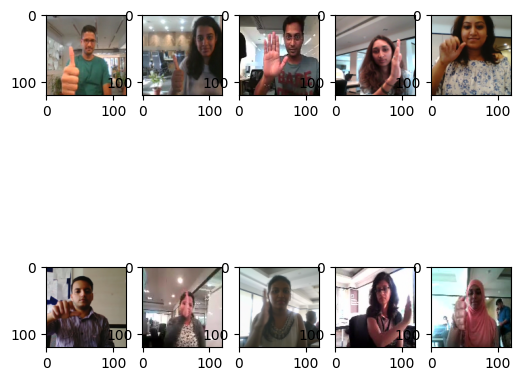

In [13]:
fig, ax = plt.subplots(2,5, figsize=(6,6))
ax[0,0].imshow(sample_batch_data[3,10,:,:,:])   
ax[0,1].imshow(sample_batch_data[6,10,:,:,:])
ax[0,2].imshow(sample_batch_data[9,15,:,:,:])   
ax[0,3].imshow(sample_batch_data[15,6,:,:,:])
ax[0,4].imshow(sample_batch_data[22,7,:,:,:])

ax[1,0].imshow(sample_val_batch_data[3,10,:,:,:])   
ax[1,1].imshow(sample_val_batch_data[6,10,:,:,:])
ax[1,2].imshow(sample_val_batch_data[9,15,:,:,:])   
ax[1,3].imshow(sample_val_batch_data[15,6,:,:,:])
ax[1,4].imshow(sample_val_batch_data[22,7,:,:,:])
plt.show()

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

Model callback utility

In [14]:
def plot_history(history):
  # """
  #   Plotting training and validation learning curves.

  #   Args:
  #     history: model history with all the metric measures
  # """
  # fig, (ax1, ax2) = plt.subplots(2)
  # fig.set_size_inches(12, 6)

  # # Plot loss
  # ax1.set_title('Loss')
  # ax1.plot(history.history['loss'], label = 'train')
  # ax1.plot(history.history['val_loss'], label = 'test')
  # ax1.set_ylabel('Loss')

  # # Determine upper bound of y-axis
  # max_loss = max(history.history['loss'] + history.history['val_loss'])

  # ax1.set_ylim([0, np.ceil(max_loss)])
  # ax1.set_xlabel('Epoch')
  # ax1.legend(['Train', 'Validation']) 

  # # Plot accuracy
  # ax2.set_title('Accuracy')
  # ax2.plot(history.history['categorical_accuracy'],  label = 'train')
  # ax2.plot(history.history['val_categorical_accuracy'], label = 'test')
  # ax2.set_ylabel('Accuracy')
  # ax2.set_ylim([0, 1])
  # ax2.set_xlabel('Epoch')
  # ax2.legend(['Train', 'Validation'])

  # plt.show()
    fig, ax = plt.subplots(1, 2, figsize=(16, 4))
    ax = ax.ravel()
    
    for i, metric in enumerate(["categorical_accuracy", "loss"]):
        ax[i].plot(model.history.history[metric])
        ax[i].plot(model.history.history["val_" + metric])
        ax[i].set_title("Model {}".format(metric))
        ax[i].set_xlabel("epochs")
        ax[i].set_ylabel(metric)
        ax[i].legend(["train", "val"])

In [15]:
def model_callbacks(folder_name):
    model_name = str(folder_name) + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
   
    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'best_model_weightdetails.weights.h5'
    # Define the ModelCheckpoint callback
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                          save_best_only=True,
                                          monitor='val_loss',
                                          save_weights_only=True,
                                          mode='min',
                                          verbose=1)
    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, cooldown=1, verbose=1) # write the REducelronplateau code here

    return [checkpoint, LR]

In [16]:
def calculate_steps(num_train_sequences, num_val_sequences, batch_size):
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    return steps_per_epoch,validation_steps

In [17]:
# Common utility to create conv 3D models
def create_3d_cnn_model(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25):

    model = Sequential()
    
    model.add(Conv3D(conv_filters[0], (3, 3, 3), padding='same', input_shape=(sample_frames,IMG_HEIGHT,IMG_WIDTH,NUM_CHANNELS)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[1], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[2], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[3], (3, 3, 3), padding='same'))    
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Flatten())
    model.add(Dense(dense_nodes[0], activation='relu'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_nodes[1],activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(NUM_CLASSES, activation='softmax'))

    opt = tf.keras.optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
    
    return model

### In this code two types of types of architectures are explored.
1) Conv 3D Model
2) Standard CNN + RNN

#### Model 1: 
Conv 3D Model with 30 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)

Now that you have written the model, the next step is to compile the model. When you print the summary of the model, you'll see the total number of parameters you have to train.

In [25]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 64  #experiment with the batch size
print ('# batch size =', batch_size)
sample_frames = 30
print ('# num_frames per video =', sample_frames)
model = create_3d_cnn_model((16, 32, 64, 128), (256,128), 0.25)

print (model.summary())

# epochs = 20
# batch size = 64
# num_frames per video = 30


2024-10-02 11:45:51.517434: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22282 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:c1:00.0, compute capability: 8.9


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_1 (Conv3D)               │ (None, 30, 120, 120,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 30, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 15, 60, 60, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 15, 60, 60, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 15, 60, 60, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 15, 60, 60, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 7, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 7, 30, 30, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 7, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 30, 30, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 3, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 3, 15, 15, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 3, 15, 15, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 3, 15, 15, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 1, 7, 7, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,933,765 (7.38 MB)

 Trainable params: 1,932,517 (7.37 MB)

 Non-trainable params: 1,248 (4.88 KB)

None


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint

callbacks_list = model_callbacks("model_arch1_conv3D_1")
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size)
val_generator   = generator(val_path, val_doc, batch_size)

In [30]:
history = model.fit(train_generator, 
                    steps_per_epoch=steps_per_epoch, 
                    epochs=num_epochs, 
                    verbose=1,        
                    callbacks=callbacks_list, 
                    validation_data=val_generator,          
                    validation_steps=validation_steps, 
                    class_weight=None, 
                    initial_epoch=0)

Epoch 1/20


I0000 00:00:1727870033.332068    1198 service.cc:146] XLA service 0x70521c018e70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727870033.332137    1198 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-10-02 11:53:53.648515: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-02 11:53:54.055977: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 1/11 ━━━━━━━━━━━━━━━━━━━━ 2:07 13s/step - categorical_accuracy: 0.2656 - loss: 2.2316

I0000 00:00:1727870043.125239    1198 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - categorical_accuracy: 0.4181 - loss: 1.7546 
Epoch 1: val_loss improved from inf to 1.71735, saving model to model_arch1_conv3D_1_2024-10-0211_40_05.031277/best_model_weightdetails.weights.h5
11/11 ━━━━━━━━━━━━━━━━━━━━ 261s 25s/step - categorical_accuracy: 0.4259 - loss: 1.7318 - val_categorical_accuracy: 0.3400 - val_loss: 1.7174 - learning_rate: 0.0010
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - categorical_accuracy: 0.7229 - loss: 0.7546 
Epoch 2: val_loss did not improve from 1.71735
11/11 ━━━━━━━━━━━━━━━━━━━━ 210s 21s/step - categorical_accuracy: 0.7244 - loss: 0.7521 - val_categorical_accuracy: 0.2000 - val_loss: 2.6357 - learning_rate: 0.0010
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - categorical_accuracy: 0.8372 - loss: 0.4909 
Epoch 3: val_loss did not improve from 1.71735
11/11 ━━━━━━━━━━━━━━━━━━━━ 226s 22s/step - categorical_accuracy: 0.8373 - loss: 0.4890 - val_categorical_accuracy: 0.2500 - val_loss: 3.8120 - learni

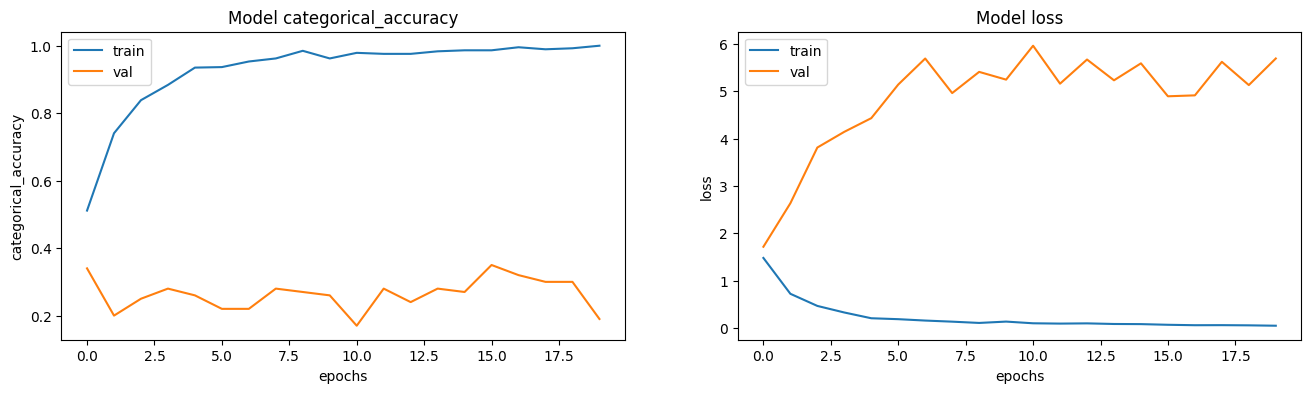

In [42]:
plot_history(history)

#### Model 2: 
Conv 3D Model with 20 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)¶

In [43]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 32  #experiment with the batch size
print ('# batch size =', batch_size)
sample_frames = 20
print ('# num_frames per video =', sample_frames)
model = create_3d_cnn_model((16, 32, 64, 128), (256,128), 0.25)

print (model.summary())

# epochs = 20
# batch size = 32
# num_frames per video = 20


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_5 (Conv3D)               │ (None, 20, 120, 120,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 20, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 20, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 10, 60, 60, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_6 (Conv3D)               │ (None, 10, 60, 60, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 10, 60, 60, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 10, 60, 60, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 5, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_7 (Conv3D)               │ (None, 5, 30, 30, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 5, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 5, 30, 30, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_6 (MaxPooling3D)  │ (None, 2, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_8 (Conv3D)               │ (None, 2, 15, 15, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 2, 15, 15, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 2, 15, 15, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_7 (MaxPooling3D)  │ (None, 1, 7, 7, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,933,765 (7.38 MB)

 Trainable params: 1,932,517 (7.37 MB)

 Non-trainable params: 1,248 (4.88 KB)

None


In [44]:
from tensorflow.keras.callbacks import ModelCheckpoint

callbacks_list = model_callbacks("model_arch1_conv3D_2")
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size)
val_generator   = generator(val_path, val_doc, batch_size)

In [45]:
history = model.fit(train_generator, 
                    steps_per_epoch=steps_per_epoch, 
                    epochs=num_epochs, 
                    verbose=1,        
                    callbacks=callbacks_list, 
                    validation_data=val_generator,          
                    validation_steps=validation_steps, 
                    class_weight=None, 
                    initial_epoch=0)

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - categorical_accuracy: 0.4051 - loss: 1.8528 
Epoch 1: val_loss improved from inf to 2.15873, saving model to model_arch1_conv3D_2_2024-10-0211_40_05.031277/best_model_weightdetails.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 281s 14s/step - categorical_accuracy: 0.4091 - loss: 1.8393 - val_categorical_accuracy: 0.2300 - val_loss: 2.1587 - learning_rate: 0.0010
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - categorical_accuracy: 0.6874 - loss: 0.8440 
Epoch 2: val_loss did not improve from 2.15873
21/21 ━━━━━━━━━━━━━━━━━━━━ 231s 12s/step - categorical_accuracy: 0.6885 - loss: 0.8420 - val_categorical_accuracy: 0.2100 - val_loss: 3.4002 - learning_rate: 0.0010
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - categorical_accuracy: 0.8491 - loss: 0.4354 
Epoch 3: val_loss did not improve from 2.15873
21/21 ━━━━━━━━━━━━━━━━━━━━ 224s 11s/step - categorical_accuracy: 0.8488 - loss: 0.4362 - val_categorical_accuracy: 0.2200 - val_loss: 4.99

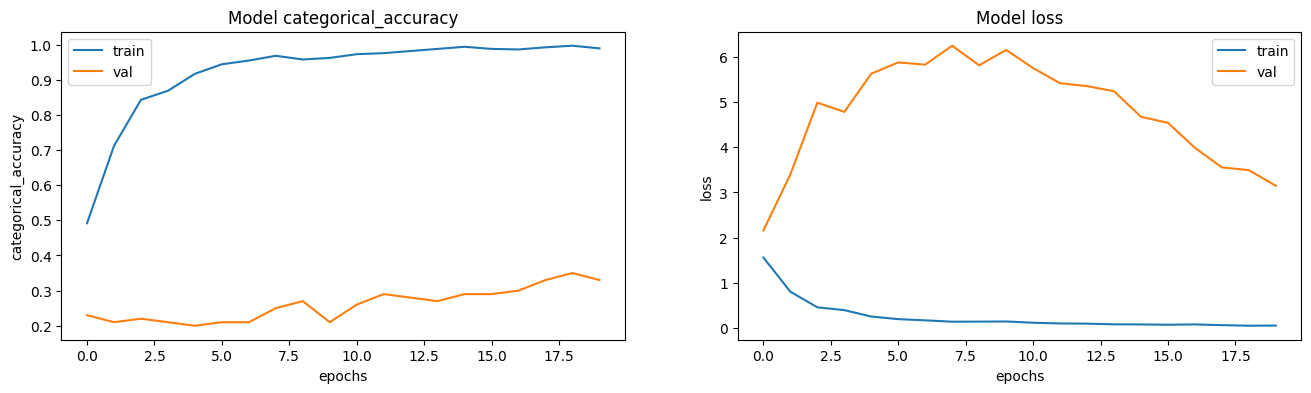

In [46]:
plot_history(history)

#### Model 3: 
Conv 3D Model with 20 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)¶

In [49]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 8  #experiment with the batch size
print ('# batch size =', batch_size)
sample_frames = 20
print ('# num_frames per video =', sample_frames)
model = create_3d_cnn_model((16, 32, 64, 128), (256,128), 0.25)

print (model.summary())

# epochs = 20
# batch size = 8
# num_frames per video = 20


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_9 (Conv3D)               │ (None, 20, 120, 120,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 20, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 20, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_8 (MaxPooling3D)  │ (None, 10, 60, 60, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_10 (Conv3D)              │ (None, 10, 60, 60, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 10, 60, 60, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 10, 60, 60, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_9 (MaxPooling3D)  │ (None, 5, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_11 (Conv3D)              │ (None, 5, 30, 30, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 5, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 5, 30, 30, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_10 (MaxPooling3D) │ (None, 2, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_12 (Conv3D)              │ (None, 2, 15, 15, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 2, 15, 15, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 2, 15, 15, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_11 (MaxPooling3D) │ (None, 1, 7, 7, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,933,765 (7.38 MB)

 Trainable params: 1,932,517 (7.37 MB)

 Non-trainable params: 1,248 (4.88 KB)

None


In [50]:
from tensorflow.keras.callbacks import ModelCheckpoint

callbacks_list = model_callbacks("model_arch1_conv3D_3")
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size)
val_generator   = generator(val_path, val_doc, batch_size)

In [51]:
with tf.device('/GPU:0'):
    history = model.fit(train_generator, 
                        steps_per_epoch=steps_per_epoch, 
                        epochs=num_epochs, 
                        verbose=1,        
                        callbacks=callbacks_list, 
                        validation_data=val_generator,          
                        validation_steps=validation_steps, 
                        class_weight=None, 
                        initial_epoch=0)

Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.3459 - loss: 1.9531
Epoch 1: val_loss improved from inf to 6.62579, saving model to model_arch1_conv3D_3_2024-10-0211_40_05.031277/best_model_weightdetails.weights.h5
83/83 ━━━━━━━━━━━━━━━━━━━━ 296s 3s/step - categorical_accuracy: 0.3466 - loss: 1.9496 - val_categorical_accuracy: 0.1700 - val_loss: 6.6258 - learning_rate: 0.0010
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.5926 - loss: 1.1270
Epoch 2: val_loss improved from 6.62579 to 5.89779, saving model to model_arch1_conv3D_3_2024-10-0211_40_05.031277/best_model_weightdetails.weights.h5
83/83 ━━━━━━━━━━━━━━━━━━━━ 268s 3s/step - categorical_accuracy: 0.5922 - loss: 1.1274 - val_categorical_accuracy: 0.1900 - val_loss: 5.8978 - learning_rate: 0.0010
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.5852 - loss: 1.1494
Epoch 3: val_loss did not improve from 5.89779
83/83 ━━━━━━━━━━━━━━━━━━━━ 255s 3s/step - 

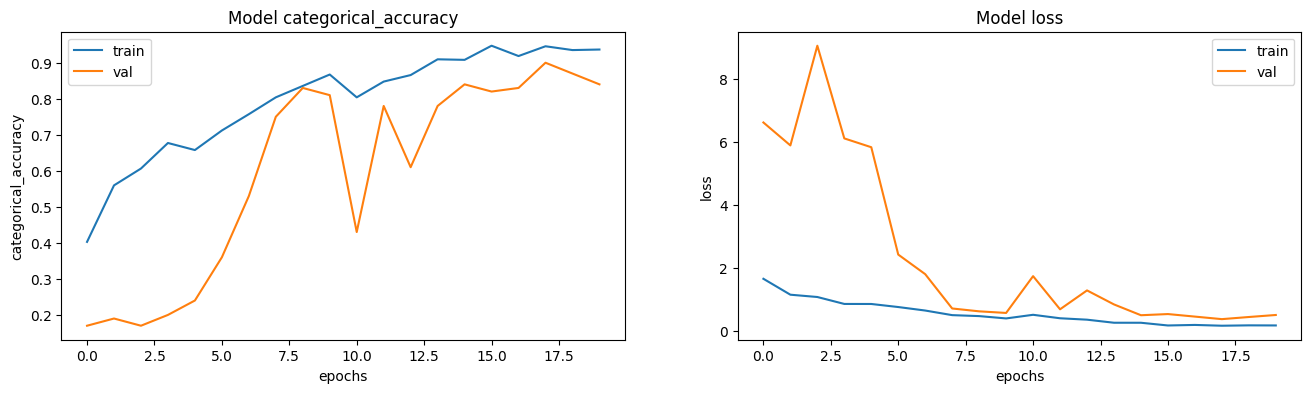

In [52]:
plot_history(history)

#### Model 4: 
Conv 3D Model with 20 frames per video (32, 64, 128, 256 filters conv 3D layers + 256 dense layer + 256 dense layer + image size 120 by 120)¶

In [19]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 16  #experiment with the batch size
print ('# batch size =', batch_size)
sample_frames = 20
print ('# num_frames per video =', sample_frames)
model = create_3d_cnn_model((32, 64, 128, 256), (256,256), 0.50)

print (model.summary())

# epochs = 20
# batch size = 16
# num_frames per video = 20


2024-10-03 01:57:23.850698: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22282 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:c1:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 20, 120, 120,   │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 20, 120, 120,   │             0 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 20, 120, 120,   │           128 │
│ (BatchNormalization)            │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 10, 60, 60, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 10, 60, 60, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 10, 60, 60, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10, 60, 60, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 5, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 5, 30, 30, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 5, 30, 30, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 5, 30, 30, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 2, 15, 15, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 2, 15, 15, 256) │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 2, 15, 15, 256) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2, 15, 15, 256) │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 1, 7, 7, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,211,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,446,853 (16.96 MB)

 Trainable params: 4,444,869 (16.96 MB)

 Non-trainable params: 1,984 (7.75 KB)

None


In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint

callbacks_list = model_callbacks("model_arch1_conv3D_4")
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size)
val_generator   = generator(val_path, val_doc, batch_size)

In [21]:
tf.debugging.set_log_device_placement(True)

In [22]:
with tf.device('/GPU:0'):
    history = model.fit(train_generator, 
                        steps_per_epoch=steps_per_epoch, 
                        epochs=num_epochs, 
                        verbose=1,        
                        callbacks=callbacks_list, 
                        validation_data=val_generator,          
                        validation_steps=validation_steps, 
                        class_weight=None, 
                        initial_epoch=0)

Epoch 1/20


I0000 00:00:1727920735.187203     847 service.cc:146] XLA service 0x751e200182e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727920735.187261     847 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-10-03 01:58:55.316516: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-03 01:58:55.708726: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 2/42 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - categorical_accuracy: 0.2031 - loss: 2.9578 

I0000 00:00:1727920743.354498     847 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.2918 - loss: 2.5108
Epoch 1: val_loss improved from inf to 3.47902, saving model to model_arch1_conv3D_4_2024-10-0301_52_24.002201/best_model_weightdetails.weights.h5
42/42 ━━━━━━━━━━━━━━━━━━━━ 284s 7s/step - categorical_accuracy: 0.2939 - loss: 2.5011 - val_categorical_accuracy: 0.2400 - val_loss: 3.4790 - learning_rate: 0.0010
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.4626 - loss: 1.5775
Epoch 2: val_loss did not improve from 3.47902
42/42 ━━━━━━━━━━━━━━━━━━━━ 254s 6s/step - categorical_accuracy: 0.4631 - loss: 1.5760 - val_categorical_accuracy: 0.2100 - val_loss: 3.5213 - learning_rate: 0.0010
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.5980 - loss: 1.1987
Epoch 3: val_loss improved from 3.47902 to 3.28945, saving model to model_arch1_conv3D_4_2024-10-0301_52_24.002201/best_model_weightdetails.weights.h5
42/42 ━━━━━━━━━━━━━━━━━━━━ 230s 6s/step - categorical

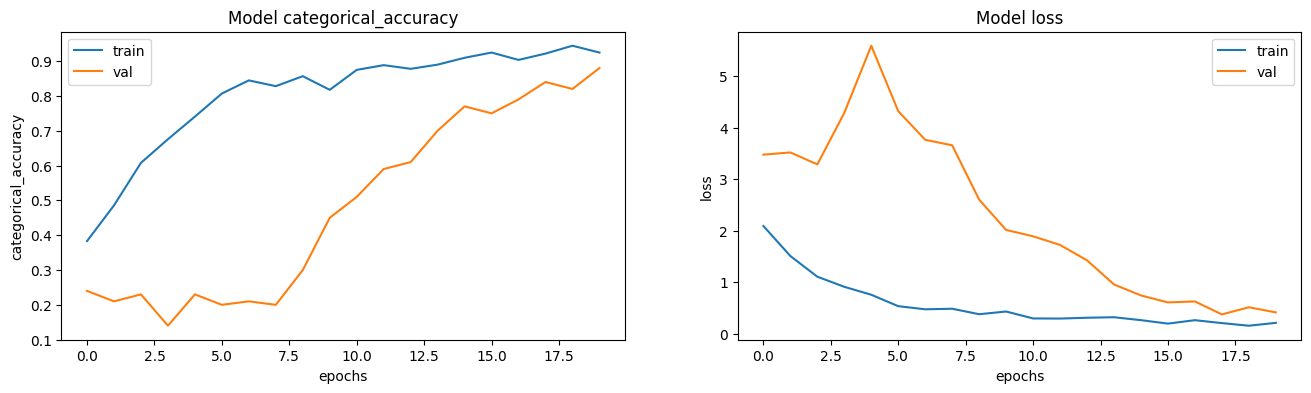

In [23]:
plot_history(history)

#### Model 5: 
TBD - Conv 3D Model with 20 frames per video (32, 64, 128, 256 filters conv 3D layers + 256 dense layer + 256 dense layer + image size 120 by 120)¶

In [ ]:
num_epochs = 20 # choose the number of epochs
#print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)

model = conv3D(num_images=num_frames)

print (model.summary())

The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make. Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
callbacks_list = model_callbacks("model_20_conv3D_2")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)
val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot_loss_accuracy(history)

#### Model 3: 
Conv 3D Model with 30 frames per video (32, 64, 128, 256) filters conv 3D layers + 128 dense layer + 128 dense layer + image size 120 by 120)

In [ ]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)

conv_filters = (32, 64, 128, 256)
dense_filters = (128, 128)
model = conv3D(conv_filters=conv_filters,dense_nodes=dense_filters, num_images=num_frames)
print (model.summary())

In [ ]:
callbacks_list = model_callbacks("model_30_conv3D_3")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)
val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot_loss_accuracy(history)

#### Model 4: 
Conv 3D Model with 20 frames per video (32, 64, 128, 256) filters conv 3D layers + 128 dense layer + 128 dense layer + image size 120 by 120)

In [ ]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)

conv_filters = (32, 64, 128, 256)
dense_filters = (128, 128)
model = conv3D(conv_filters=conv_filters,dense_nodes=dense_filters, num_images=num_frames)
print (model.summary())

In [ ]:
callbacks_list = model_callbacks("model_20_conv3D_3")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)
val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot_loss_accuracy(history)

### TRANSFER LEARNING - MobileNet Conv2d + GRU

In [ ]:
from keras.applications import mobilenet

def mobilenet_RNN_GRU_LSTM((fine_tune=False, gru=False, lstm_gru_cells=128, dense_nodes=128, dropout=0.25, num_images=20, height=120, width=120):

    mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
    print("Number of layers in the pretrained mobilenet model: ", len(mobilenet_transfer.layers))

    if (fine_tune):
        # Fine-tune from this layer onwards
        fine_tune_at = 50
        # Freeze all the layers before the `fine_tune_at` layer
        for layer in mobilenet_transfer.layers[:fine_tune_at]:
            layer.trainable = False

    model = Sequential()
    model.add(TimeDistributed(mobilenet_transfer,input_shape=(num_images, height, width, 3)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(keras.layers.MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    if (gru):
        model.add(GRU(lstm_gru_cells))
    else:
        model.add(LSTM(lstm_gru_cells))
    model.add(Dropout(dropout))
    model.add(Dense(dense_nodes, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))

    opt = tf.keras.optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
    return model

#### Model 5: 
Mobilenet (re train all weights) + GRU (128 cells) + 128 dense nodes

In [ ]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)

model = mobilenet_RNN_GRU_LSTM((gru=True, num_images=num_frames)
print (model.summary())

In [ ]:
callbacks_list = model_callbacks("model_20_retrain_mobilenet_gru")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)
val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot_loss_accuracy(history)

#### Model 6: 
Mobilenet (re train all weights) + GRU (128 cells) + 128 dense nodes + Random data transformations on training data set

In [ ]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num frames per video =', num_frames)

model = mobilenet_RNN_GRU_LSTM((gru=True, num_images=num_frames)
print(model.summary())

In [ ]:
callbacks_list = model_callbacks("model_30_retrain_mobilenet_gru")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)
val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot_loss_accuracy(history)

#### Model 7: 
Mobilenet 20 frames (re train all wieghts) + LSTM (128 cells) + 128 dense nodes

In [ ]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)

model = mobilenet_RNN_GRU_LSTM((gru=False, num_images=num_frames)
print(model.summary())

In [ ]:
callbacks_list = model_callbacks("model_20_retrain_mobilenet_lstm")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)
val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot_loss_accuracy(history)

#### Model 8: 
Mobilenet 30 frames (re train all wieghts) + LSTM (128 cells) + 128 dense nodes

In [ ]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num frames per video =', num_frames)

model = mobilenet_RNN_GRU_LSTM((gru=False, num_images=num_frames)
print(model.summary())

In [ ]:
callbacks_list = model_callbacks("model_30_retrain_mobilenet_lstm")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)
val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot_loss_accuracy(history)

### Load Selected Model
Loading the selected model from the disk 

In [ ]:
# model-00016-0.03003-0.99548-0.05517-0.98000.h5

from keras.models import load_model
model = load_model('model-00016-0.03003-0.99548-0.05517-0.98000.h5')
model.summary()